# Clinical Neuro-Oncology EDA & Modeling

## 1. Setup & Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

In [3]:
import pandas as pd
import os
import torch
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from src.utils import validate_dataset_structure, run_features_df_checks, seed_everything
from src.preprocessing import compute_dicom_features_df
from src.models import build_resnet18_binary
from src.eval import eval_many_thresholds, sample_and_plot_raw_mask_prep_grid, plot_cv_mean_roc, plot_cv_mean_pr, plot_test_roc_pr
from src.cv import run_cv
from src.final_model import train_final_and_score_test

pd.set_option('display.max_columns', None)

/mnt/work/projects/clinical-neuro-oncology/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Reproducibility and split settings
SEED = 42
K_FOLDS = 5
TEST_SIZE = 0.15

# Runtime / loader settings
BATCH_SIZE = 500
PIN_MEMORY = True
PROCESSES = os.cpu_count()

# Dataset paths
DATA_ROOT = "../data/"
LABELS = "labels1.csv"
CTS = "CTs"

# Device selection (GPU if available)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"number of cpus: {PROCESSES} | fast or slow: {DEVICE}")

# Seed all random sources for reproducibility (same as main.py)
seed_everything(SEED)

# Basic data-folder sanity check
validate_dataset_structure(DATA_ROOT)

number of cpus: 4 | fast or slow: cuda

Validating dataset structure...

CT folder found: ../data/CTs
   → 5123 DICOM files detected
No duplicate CT filenames detected

Labels file found: ../data/labels1.csv
   → 5122 rows
   → Columns: ['Unnamed: 0', 'ID', 'Label']

Duplicates check:
   → Duplicate IDs in labels: 0

Class distribution:
Label
0    4843
1     279
Name: count, dtype: int64

Class imbalance:
   → Positive rate (Label=1): 0.054
   → Negative rate (Label=0): 0.946
   → Imbalance ratio (neg/pos): 17.36

Detected duplicate-like CT files (ignored):
   → ID_0af83a8d9 (1).dcm
   → Total ignored duplicates: 1

ID ↔ filename cross-check:
   → Missing CT files for labels: 0
   → Extra CT files without labels (after cleaning duplicates): 0

Dataset structure + integrity validation PASSED.



## 2. Load Labels, DICOM Paths and Feature Extraction / Preprocessing


In [5]:
# Load labels table (ID -> label) and resolve CT directory path.
labels_df = pd.read_csv(os.path.join(DATA_ROOT, LABELS), index_col="ID")
ct_dir = os.path.join(DATA_ROOT, CTS)

# Build per-study features from DICOM files (includes image array and metadata).
features_df = compute_dicom_features_df(ct_dir, labels_df, processes=PROCESSES)

# Quick preview to verify extraction succeeded.
features_df.head(2)

Extracting features: CTs:   0%|          | 0/5122 [00:00<?, ?it/s]

Extracting features: CTs: 100%|██████████| 5122/5122 [00:21<00:00, 234.98it/s]


,path,label,ok,error,pixel_spacing_x,pixel_spacing_y,slice_thickness,orientation,window_center,window_width,shape_0,shape_1,hu_min,hu_max,hu_mean,pixel_array_min,pixel_array_max,pixel_array_mean,img
id,,,,,,,,,,,,,,,,,,,
ID_00c01bbdc,../data/CTs/ID_00c01bbdc.dcm,0,1,None,0.488281,0.488281,None,"[1.000000, 0.000000, 0.000000, 0.000000, 0.953...",30.0,80.0,512,512,-1024.0,1740.0,-479.384186,-2000.0,2764.0,119.109222,"[[-998.0, -997.0, -999.0, -998.0, -997.0, -999..."
ID_00c0352f1,../data/CTs/ID_00c0352f1.dcm,0,1,None,0.488281,0.488281,None,"[1.000000, 0.000000, 0.000000, 0.000000, 0.942...",30.0,80.0,512,512,-1024.0,1842.0,-450.834503,-2000.0,2866.0,147.658936,"[[-999.0, -1001.0, -1002.0, -999.0, -1002.0, -..."


In [6]:
checks = run_features_df_checks(features_df)

=== Missing Values (key columns) ===
       missing_count
img                0
label              0

=== Top Missing Counts (all columns) ===
                  missing_count
error                      5122
slice_thickness            5122
path                          0
ok                            0
label                         0
pixel_spacing_x               0
pixel_spacing_y               0
orientation                   0
window_center                 0
window_width                  0
shape_0                       0
shape_1                       0
hu_min                        0
hu_max                        0
hu_mean                       0
pixel_array_min               0
pixel_array_max               0
pixel_array_mean              0
img                           0

=== Intensity Summary ===
                   count         mean          std           min          25%  \
hu_min            5122.0 -1024.042757     1.039320  -1060.000000 -1024.000000   
hu_max            5122.0  168

## 3. Train/Test Split Strategy

In [7]:
# Create a stratified train/test split on patient IDs to preserve class ratio.
train_idx, test_idx = train_test_split(
    features_df.index,
    test_size=TEST_SIZE,
    stratify=features_df["label"],
    random_state=SEED
)

# Mark split membership as proper bool column (same as main.py).
features_df["test"] = features_df.index.isin(test_idx)

# Quick sanity check: label distribution by split flag.
print(features_df.groupby('test').agg('label').value_counts())
features_df[['img','label','test']].head()

test   label
False  0        4116
       1         237
True   0         727
       1          42
Name: count, dtype: int64


,img,label,test
id,,,
ID_00c01bbdc,"[[-998.0, -997.0, -999.0, -998.0, -997.0, -999...",0,False
ID_00c0352f1,"[[-999.0, -1001.0, -1002.0, -999.0, -1002.0, -...",0,False
ID_00c037c09,"[[-1000.0, -998.0, -998.0, -1000.0, -998.0, -9...",0,False
ID_00c039b01,"[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...",0,True
ID_00c0623de,"[[-1006.0, -1004.0, -1002.0, -1001.0, -1001.0,...",1,False


## 4. Preprocessing Examples

### Preprocessing Visualization Workflow

This visualization samples `n` training examples from a selected label (`0` or `1`) and shows each preprocessing stage side-by-side.

For every sampled DICOM:
1. **Raw HU conversion**: pixel values are converted to Hounsfield Units using `RescaleSlope` and `RescaleIntercept`, with very low outliers floored to `-1024`.
2. **Skull mask**: a binary mask is created using a high-intensity threshold (`HU > percentile`).
3. **Skull-based crop**: the image is cropped to the skull bounding box.
4. **Brain windowing (3 sub-windows)**: the range `[center - width/2, center + width/2]` is divided into 3 equal sub-ranges, each normalized to `[0,1]` independently.

The output is plotted as an `n x 6` grid:
**Raw HU -> Skull Mask -> Cropped -> Window 1 (low HU) -> Window 2 (mid HU) -> Window 3 (high HU)**,

with each row indexed by the original sample ID from `features_df`.

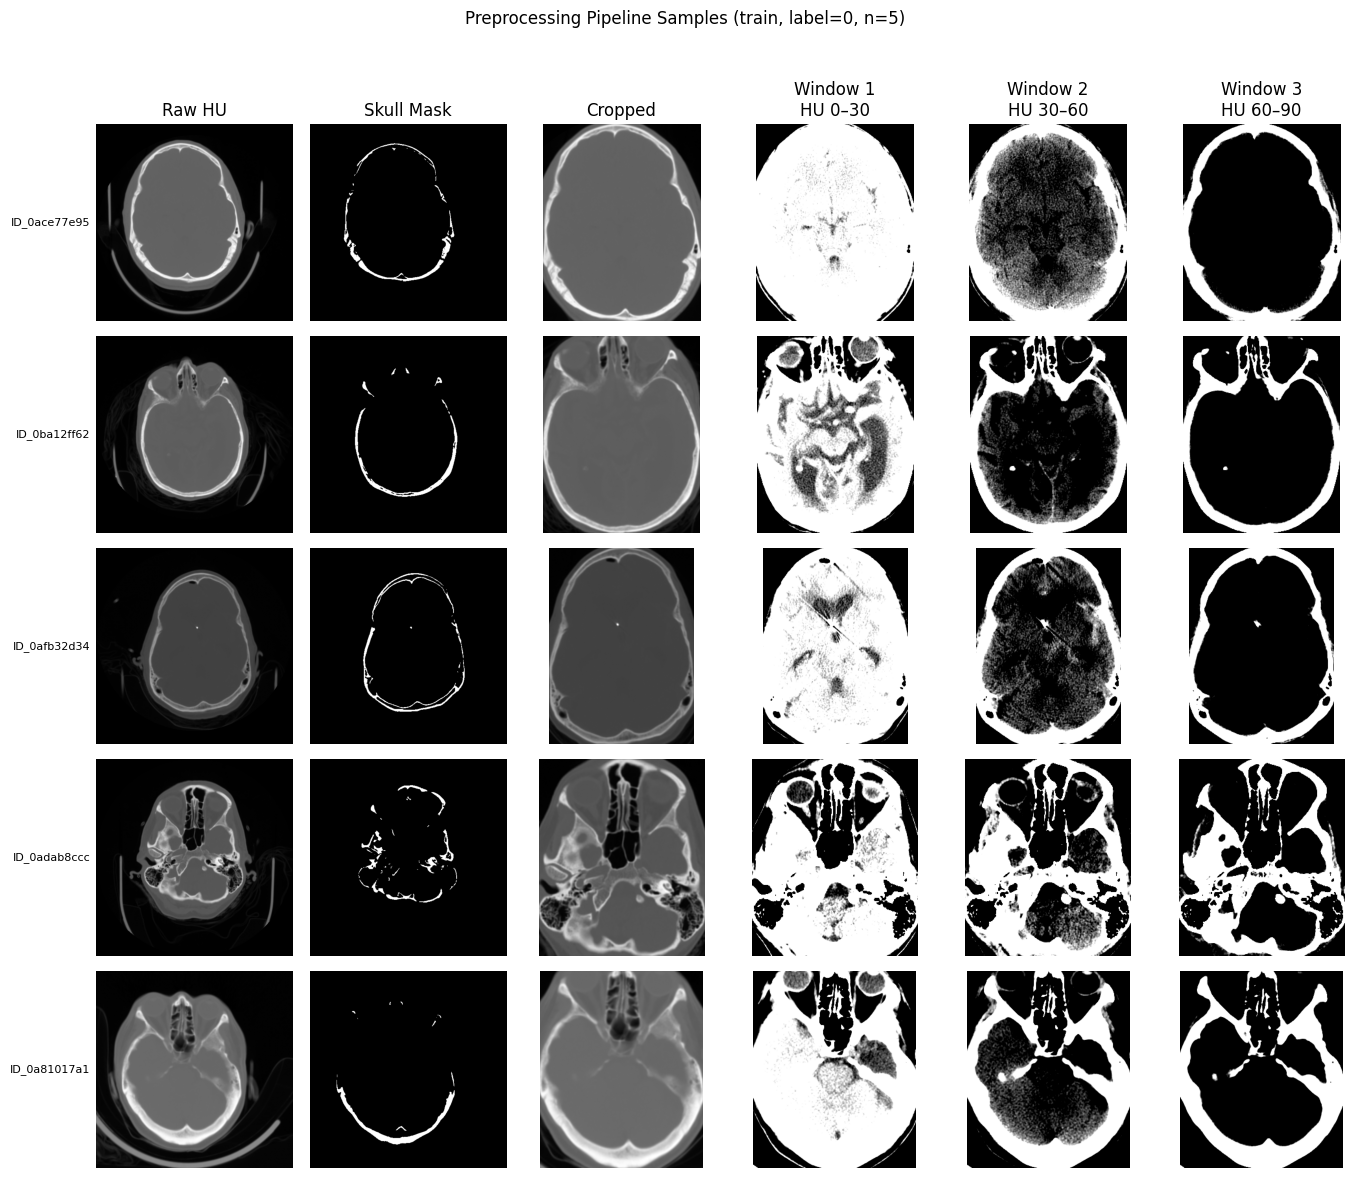

In [8]:
# Label 0 examples (negative class): visualize raw -> skull mask -> cropped -> brain-windowed preprocessing steps.
out_l1 = sample_and_plot_raw_mask_prep_grid(features_df, 5, random_state=20, label=0,
                                            window_center=45,window_width=90
                                            )

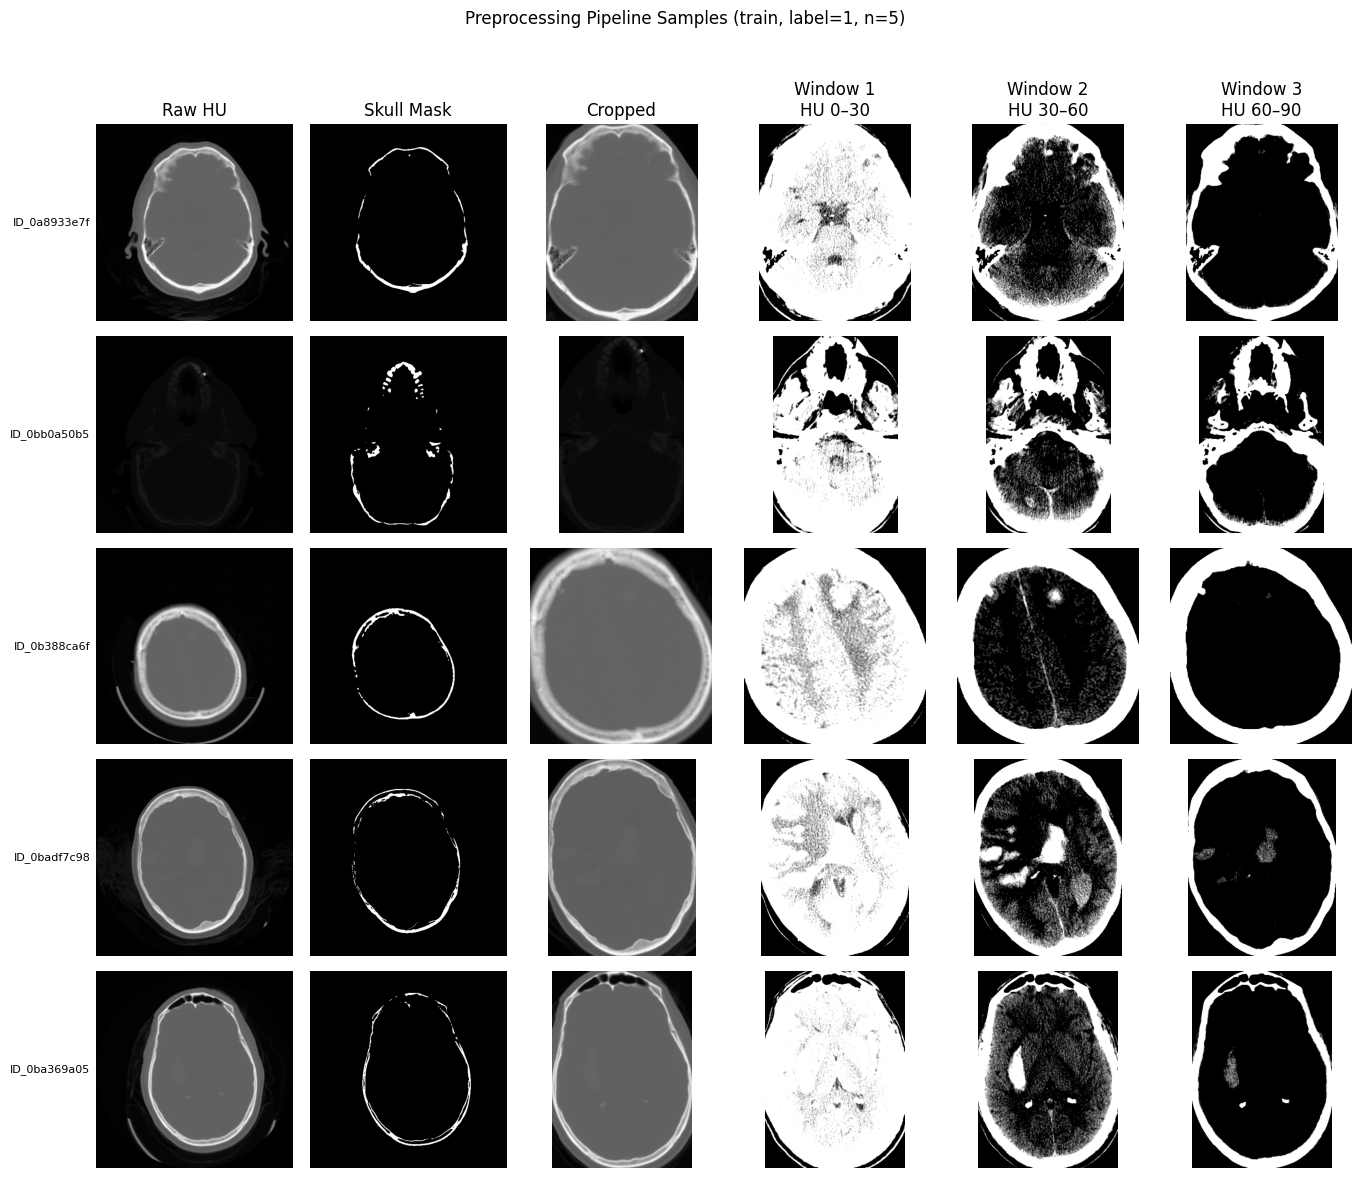

In [9]:
# Label 1 examples (positive class): visualize the same preprocessing pipeline for comparison against label 0.
out_l1 = sample_and_plot_raw_mask_prep_grid(features_df, 5, random_state=20, label=1,
                                            window_center=45,window_width=90
                                            )

## 5. Model Input Transforms (after preprocessing)

After skull-based crop and brain windowing, each image is passed through the model transform pipeline:

1. **ToFloatTensorCHW**  
   Converts the stacked 3-window array to `float32` tensor in channel-first format `(3, H, W)`.

2. **ResizeLetterbox (to fixed size)**  
   Resizes while preserving aspect ratio, then pads to the target size (`out_size x out_size`) to avoid geometric distortion. Applied identically across all 3 channels.

3. **Train-time augmentation (train only)**  
   Applies `RandomAffine` (rotation ±15°, translation ±5%, scale 0.90–1.10) and random horizontal flip. Also applies `GaussianBlur` (kernel 3, σ 0.1–1.5) to simulate resolution and acquisition variation. The same spatial transform is applied consistently to all 3 channels.

4. **ImageNet normalization**  
   Normalizes using ImageNet mean/std per channel to align with pretrained ResNet feature scaling.

5. **RandomErasing (train only, after normalization)**  
   Randomly masks rectangular patches (p=0.3, scale 2–15% of image area) to simulate imaging artifacts and prevent the model from relying on any single image region.

This produces a fixed-size, normalized 3-channel tensor ready for model input. Each channel encodes a different HU contrast range, giving the model complementary tissue visibility instead of three identical copies of the same image.

## 6. CV Training Function


### Cross-Validation Pipeline (`run_cv`)

`run_cv` executes the end-to-end cross-validation workflow used for model selection and threshold analysis.

#### What it does
1. Uses only the training pool (`test == False`).
2. Builds **Stratified K-Fold** splits.
3. For each fold:
   - Creates train/validation datasets and loaders.
   - Applies **WeightedRandomSampler** on the training loader to handle class imbalance.
   - Builds a binary ResNet model and loss function.
   - Runs **warmup** (head-only training) with optional cosine LR annealing and label smoothing.
   - Runs **fine-tuning** (selected layers via `ft_trainable_attrs`, or all layers if `None`) with the same schedule and smoothing options.
   - Keeps the best checkpoint based on **validation AUPRC**.
   - Stores fold metrics and out-of-fold (OOF) predictions.
4. After all folds:
   - Computes mean/std CV performance.
   - Concatenates OOF predictions across folds.
   - Computes threshold tables:
     - `df_all`: per-fold, per-threshold metrics
     - `df_summary`: aggregated mean/std metrics by threshold

#### Main outputs
- `mean_metric`, `std_metric`
- `fold_metrics`, `histories`, `best_models`
- `oof_true`, `oof_prob`, `oof_ids`
- `y_true_fold`, `y_score_fold`
- `df_all`, `df_summary`

## 7. Model Architecture

The model is a **ResNet-18 binary classifier** initialized from ImageNet pretrained weights.

#### Backbone
- `torchvision.models.resnet18(...)`
- Convolutional feature extractor (`conv1`, `bn1`, `layer1`-`layer4`, global average pooling).

#### Classification head (custom)
The original 1000-class FC layer is replaced with:

```python
nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features, 1)  # single logit for binary classification
)
```

In [10]:
model = build_resnet18_binary(pretrained=True, dropout_p=0.4)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 8. Grid Search Strategy

We used a focused, iterative grid-search process to tune the training pipeline under class imbalance and overfitting constraints.

#### Objective
Select a robust configuration that maximizes validation quality (primarily AUPRC) while maintaining stable cross-validation behavior and controllable train-vs-validation gap.

#### Search approach
- **Cross-validated evaluation** was used for every candidate configuration (Stratified K-Fold).
- Tuning was done in **small, targeted batches** of configurations rather than one large exhaustive sweep.
- Each iteration adjusted only a few related hyperparameters to keep comparisons interpretable.
- Candidate sets were centered around the current best region and refined progressively.

#### Selection criteria
- Primary: **mean validation AUPRC** across folds.
- Secondary: fold-to-fold stability (std), threshold behavior (`df_summary`), and overfitting indicators (`auc_mean_trn` vs `auc_mean`).

#### Why this strategy
A fully exhaustive search was not practical; therefore, we prioritized a pragmatic search around promising regions, combined with repeated CV diagnostics, to converge on a stable and deployable final configuration.


## 9. Overfitting Mitigation Strategies Used

During model development, we applied multiple complementary strategies to reduce overfitting and improve generalization stability.

#### 1. Stratified Cross-Validation
- Used Stratified K-Fold CV to evaluate performance across multiple splits.
- Reduced dependence on a single train/validation split and provided fold-level variance tracking.

#### 2. Out-of-Fold (OOF) Evaluation
- Collected OOF predictions for threshold analysis.
- Helped evaluate decision thresholds on unseen fold data rather than in-fold predictions.

#### 3. Early Stopping on Validation AUPRC
- Applied early stopping with patience during warmup and fine-tuning.
- Prevented unnecessary late-epoch fitting after validation performance plateaued.

#### 4. Two-Stage Training
- Warmup stage trained only the classification head first.
- Fine-tuning stage updated deeper layers afterward, reducing abrupt overfitting from full-network updates at the start.

#### 5. Layer-Selective Fine-Tuning
- Introduced configurable fine-tune scope (`ft_trainable_attrs`), e.g. `["layer3", "layer4", "fc"]`.
- Allowed controlling model capacity during fine-tuning instead of always unfreezing all layers.

#### 6. Regularization Tuning
- Tuned weight decay separately for head and fine-tune stages (`weight_decay_head`, `weight_decay_ft`).
- Added dropout in the classifier head (`dropout_p`) to reduce co-adaptation.

#### 7. Imbalance Handling by Sampling
- Replaced loss-based class weighting with `WeightedRandomSampler` in training loader.
- Improved class exposure per epoch and reduced sensitivity to imbalance-driven overfit behavior.

#### 8. Data Augmentation
- Applied anatomy-safe geometric transforms: `RandomAffine` (rotation ±15°, translation ±5%, scale 0.90–1.10), random horizontal flip, and `GaussianBlur` to simulate acquisition variation.
- Added `RandomErasing` (post-normalization) to randomly mask image patches and prevent over-reliance on localized regions.

#### 9. Cosine LR Schedule
- Applied `CosineAnnealingLR` during both warmup and fine-tuning stages.
- Smoothly decays the learning rate to near zero by the last epoch, reducing the risk of late-epoch memorization.

#### 10. Label Smoothing
- Replaced hard binary targets (0/1) with soft targets during training (`label_smoothing=0.05`).
- Reduces model overconfidence on training examples and improves calibration.

#### 11. Threshold Selection Discipline
- Selected thresholds from CV/OOF statistics (`df_summary`) rather than test data.
- Avoided threshold tuning leakage into final test evaluation.

#### 12. Final Training Protocol Separation
- Used CV for hyperparameter/threshold selection.
- Trained final model separately on non-test data with frozen choices, then evaluated test once.
- This separation reduced optimization bias on the test split.


In [11]:
# from src.grids import grid

# results = []
# for i, item in enumerate(grid, 1):
#     name = item["name"]
#     cfg = item["config"].copy()
#     t0 = time.time()
#     res = run_cv(features_df, config=cfg)
#     dt = time.time() - t0
#     results.append({
#         "name": name,
#         "mean": res["mean_metric"],
#         "std": res["std_metric"],
#         "seconds": dt,
#         "cfg": cfg,
#         "res": res,  # full output stored
#     })
#     print(i, name, cfg, "=>", res["mean_metric"], "+/-", res["std_metric"], "time", dt)
#     break

# results_sorted = sorted(results, key=lambda r: r["mean"], reverse=True)

In [12]:
# Final CV verification run:
# After multiple grid-search iterations, we selected the configuration that gave
# the best validation AUPRC with the most acceptable overfitting profile
# (based on train-vs-validation gap and fold stability), and rerun CV here.

cfg = {
    "optimizer": "adamw",
    "lr_ft": 0.0001,
    "lr_head": 0.003,
    "weight_decay_head": 0.00005,
    "weight_decay_ft": 0.002,
    "epochs_head": 12,
    "epochs_ft": 12,
    "patience_head": 2,
    "patience_ft": 3,
    "dropout_p": 0.4,
    "ft_trainable_attrs": ["layer3", "layer4", "fc"],
    "label_smoothing": 0.05,
    "use_cosine_schedule": True,
}

res = run_cv(features_df, config=cfg)

print("CV mean AUPRC:", res["mean_metric"], "+/-", res["std_metric"])
display(res["df_summary"])

CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

CV folds: 100%|██████████| 5/5 [25:29<00:00, 305.93s/it, fold=5, best_metric=0.6568]

CV mean AUPRC: 0.7138110528380692 +/- 0.049579728895680096


,threshold,sens_mean,sens_std,spec_mean,spec_std,ppv_mean,ppv_std,npv_mean,npv_std,f1_mean,f1_std,acc_mean,acc_std,ap_mean,ap_std,auc_mean_trn,auc_mean,auc_std,tp_sum,fp_sum,tn_sum,fn_sum
0,0.05,0.847784,0.036193,0.847421,0.016643,0.243432,0.016246,0.989807,0.002196,0.377879,0.019366,0.847602,0.014783,0.713811,0.055432,0.999671,0.914743,0.035914,201,628,3488,36
1,0.10,0.788564,0.055860,0.924927,0.011795,0.379361,0.035600,0.987054,0.003200,0.511165,0.035782,0.856745,0.026482,0.713811,0.055432,0.999671,0.914743,0.035914,187,309,3807,50
2,0.15,0.750621,0.048340,0.948737,0.006151,0.458749,0.036549,0.985121,0.002699,0.568909,0.037005,0.849679,0.024492,0.713811,0.055432,0.999671,0.914743,0.035914,178,211,3905,59
3,0.20,0.725266,0.056518,0.960399,0.005331,0.514573,0.042059,0.983831,0.003126,0.601342,0.041795,0.842833,0.028387,0.713811,0.055432,0.999671,0.914743,0.035914,172,163,3953,65
4,0.25,0.721011,0.061297,0.966230,0.005030,0.552740,0.047471,0.983684,0.003389,0.625040,0.047034,0.843620,0.030993,0.713811,0.055432,0.999671,0.914743,0.035914,171,139,3977,66
5,0.30,0.712589,0.057843,0.970361,0.005115,0.582267,0.052336,0.983265,0.003181,0.640108,0.048609,0.841475,0.029532,0.713811,0.055432,0.999671,0.914743,0.035914,169,122,3994,68
6,0.35,0.695745,0.053818,0.974977,0.003890,0.616671,0.042165,0.982382,0.002897,0.653046,0.039595,0.835361,0.026837,0.713811,0.055432,0.999671,0.914743,0.035914,165,103,4013,72
7,0.40,0.678723,0.070560,0.978135,0.003740,0.641816,0.054631,0.981482,0.003846,0.658945,0.056022,0.828429,0.035827,0.713811,0.055432,0.999671,0.914743,0.035914,161,90,4026,76
8,0.45,0.661879,0.069767,0.981779,0.004461,0.678301,0.065064,0.980595,0.003798,0.668823,0.059093,0.821829,0.035547,0.713811,0.055432,0.999671,0.914743,0.035914,157,75,4041,80
9,0.50,0.645124,0.064862,0.985910,0.003276,0.725798,0.056326,0.979727,0.003513,0.682123,0.054244,0.815517,0.032910,0.713811,0.055432,0.999671,0.914743,0.035914,153,58,4058,84


### Threshold Table Interpretation (Current Run)

This table reports performance at each threshold (`0.05` to `0.95`) using cross-validated predictions.

#### How to read columns
- `sens_mean` / `sens_std`: average sensitivity (recall for label 1) across folds.
- `spec_mean` / `spec_std`: average specificity (recall for label 0) across folds.
- `ppv_mean` / `npv_mean`: precision and negative predictive value across folds.
- `f1_mean` / `f1_std`: harmonic mean of precision and recall (positive class).
- `acc_mean`: balanced accuracy.
- `ap_mean`: average precision (AUPRC), threshold-independent within this run.
- `auc_mean`: ROC-AUC, threshold-independent within this run.
- `auc_mean_trn`: train ROC-AUC (used to monitor train/val gap).
- `tp_sum`, `fp_sum`, `tn_sum`, `fn_sum`: pooled confusion counts across folds.

---

### Final Threshold Selection Rationale

For the final operating point, the threshold was selected to **maximize sensitivity** in order to minimize missed positive patients (false negatives).

#### Why this choice
In this clinical setting, missing a true positive is costlier than generating additional false positives.  
Therefore, threshold optimization prioritized **patient safety / recall** over precision.

#### Practical implication
- Chosen threshold is in the region with the highest (or clinically acceptable maximum) `sens_mean`.
- This increases detection rate of positive cases.
- Tradeoff: lower threshold typically reduces specificity/PPV and increases false positives.

This threshold policy was fixed using CV-derived statistics and then applied to final test inference.


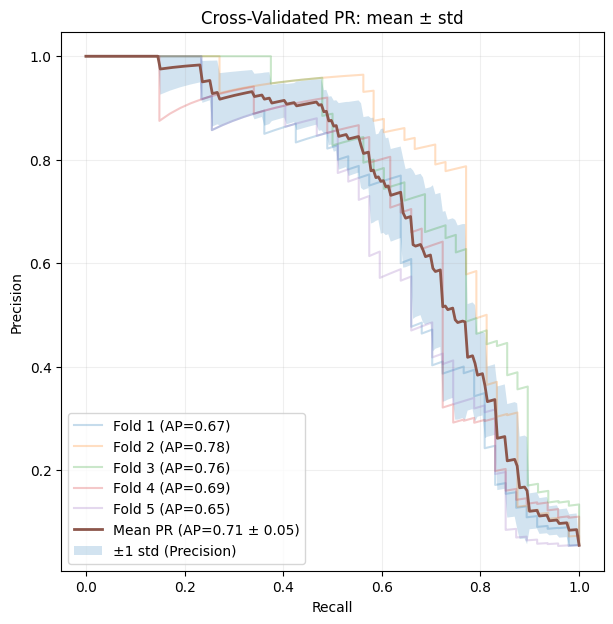

In [13]:
plot_cv_mean_pr(res["y_true_fold"], res["y_score_fold"])

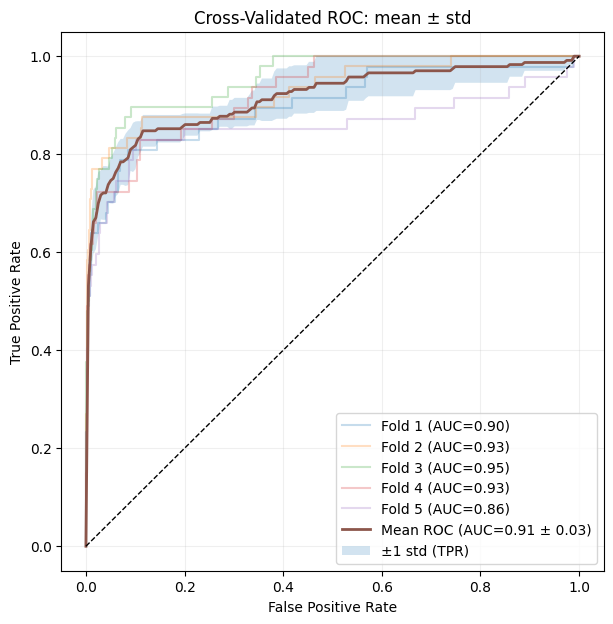

In [14]:
plot_cv_mean_roc(res["y_true_fold"], res["y_score_fold"])

## 10. Final Model Test Evaluation

This cell trains the final model with the selected configuration on the non-test data, then evaluates performance on the test set.

#### Steps performed
1. **Train + infer on test**
   - `train_final_and_score_test(...)` returns:
     - `model`: trained final model
     - `test_pred_df`: test predictions with probability scores (`prob`)

2. **Build aligned ground-truth labels**
   - `y_true` is extracted from `features_df["label"]` using `test_pred_df.index` to ensure correct ID-level alignment.

3. **Use probability outputs for scoring**
   - `y_prob` is taken from `test_pred_df["prob"]`.

4. **Threshold-based table on test**
   - `eval_many_thresholds(...)` is applied to selected threshold (e.g. `0.05`) to inspect sensitivity/specificity/PPV/NPV/F1 tradeoffs.

5. **Global ranking metrics**
   - `ROC-AUC` and `AUPRC` are computed from `y_true` and `y_prob` (probabilities, not hard labels).

#### Important note
`ROC-AUC` and `AUPRC` must be computed on **probabilities** (`y_prob`), not binary predictions (`y_pred`), to correctly reflect ranking performance.


In [15]:
model, test_pred_df = train_final_and_score_test(features_df, cfg=cfg, batch_size=16, num_workers=4)

# ground truth labels aligned to prediction index
y_true = features_df.loc[test_pred_df.index, "label"].astype(int).values

# model probabilities
y_prob = test_pred_df["prob"].values

thr_df_test = eval_many_thresholds(
    y_true=y_true,
    y_score=y_prob,
    thresholds=[0.05], # selected thresholds
    fold=None
)
display(thr_df_test)

# AUC/AP should use probabilities, not y_pred
test_auc = roc_auc_score(y_true, y_prob)
test_ap = average_precision_score(y_true, y_prob)

print("Test ROC-AUC:", test_auc)
print("Test AUPRC:", test_ap)

,fold,threshold,sens,spec,ppv,npv,f1,precision_avg,accuracy_avg,tp,tn,fp,fn,p,n
0,None,0.05,0.833333,0.834938,0.225806,0.988599,0.35533,0.640925,0.834136,35,607,120,7,42,727


Test ROC-AUC: 0.9132770026855308
Test AUPRC: 0.6409250242964973


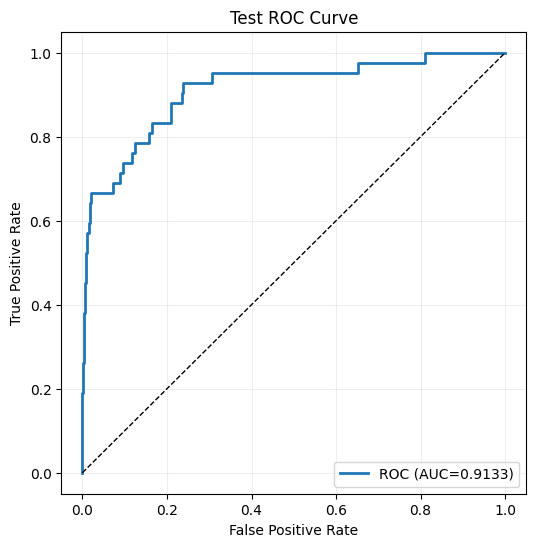

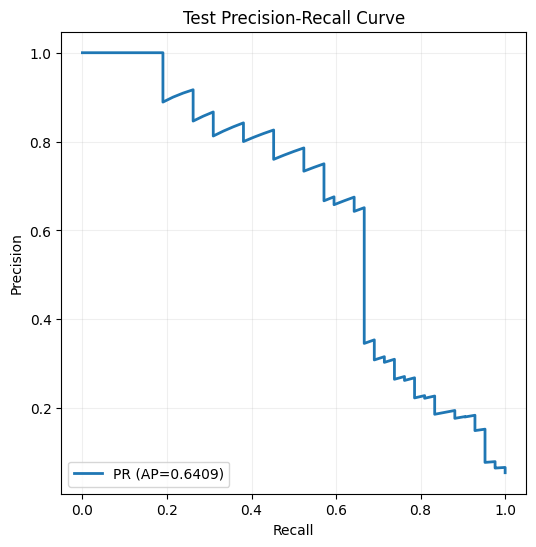

{'roc_auc': 0.9132770026855308, 'auprc': 0.6409250242964973}


In [16]:
metrics = plot_test_roc_pr(y_true, y_prob)
print(metrics)